In [19]:
import torch
from torch import nn

from scripts import mnist, train, utils

from matplotlib import pyplot as plt

import cv2

device = "cpu"

In questo *notebook*, avremo a nostra disposizione 3 reti neurali addestrate a riconoscere cifre scritte a mano dal dataset MNIST.

Le 3 reti si differenziano per complessità e tipi di strati intermedi.

In [25]:
nn1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
).to(device)

nn2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
).to(device)

nn3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 200),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 200),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 10)
).to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=64, bias=True)
  (2): ReLU()
  (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=64, out_features=200, bias=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): ReLU()
  (7): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=200, out_features=200, bias=True)
  (9): Dropout(p=0.5, inplace=False)
  (10): ReLU()
  (11): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=200, out_features=10, bias=True)
)

Carichiamo i dati...

In [3]:
trainloader, testloader, _, _, data_transforms = mnist.get_data(batch_size_train=128)

e visualizziamo un po' di immagini a caso dal dataset di addestramento:

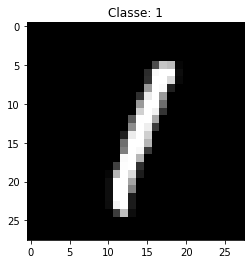

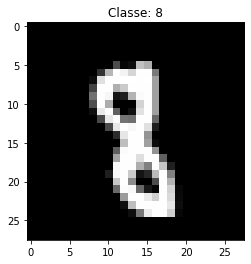

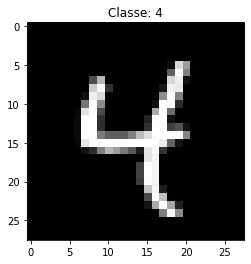

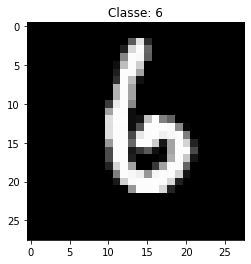

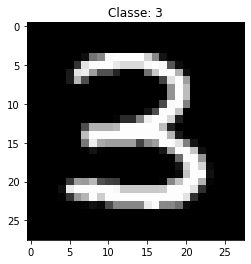

In [4]:
batch = next(iter(trainloader))
for i in torch.randint(batch[0].shape[0], [5]):
    utils.show_bw_image(batch[0][i], f"Classe: {batch[1][i]}")

I modelli sono già stati addestrati _ad latere_ e i pesi e bias salvati nella cartella `models`. Provvediamo a caricare i pesi...

In [26]:
nn1.load_state_dict(torch.load("models/model1.pt", map_location=device)["parameters"])
nn2.load_state_dict(torch.load("models/model2.pt", map_location=device)["parameters"])
nn3.load_state_dict(torch.load("models/model3.pt", map_location=device)["parameters"])

<All keys matched successfully>

... e vediamo qual è la performance sul dataset di test

In [16]:
_ = train.test_model(nn1, testloader, loss_fn=nn.CrossEntropyLoss())
_ = train.test_model(nn2, testloader, loss_fn=nn.CrossEntropyLoss())
_ = train.test_model(nn3, testloader, loss_fn=nn.CrossEntropyLoss())

TESTING - loss 6752.060141086578 - performance 0.9676
TESTING - loss 5701.789524078369 - performance 0.9708
TESTING - loss 3507.754098176956 - performance 0.9821


Ora, andiamo ad estrarre un po' di immagini a caso dal **dataset di test**

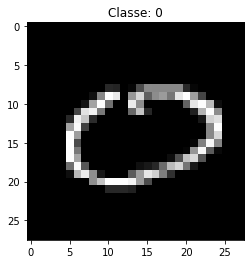

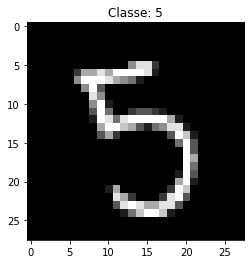

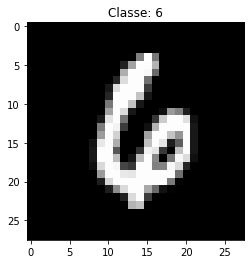

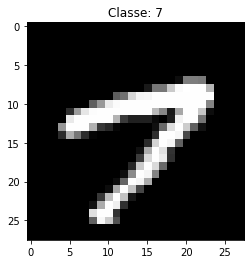

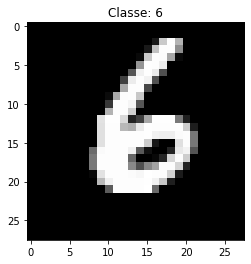

In [7]:
numero_immagini_prova = 5
data, labels = utils.random_data_extractor(testloader, numero_immagini_prova)
for i in range(numero_immagini_prova):
    utils.show_bw_image(data[i], title=f"Classe: {labels[i].item()}")

Vediamo ora come si comportano i nostri modelli su queste immagini casuali...

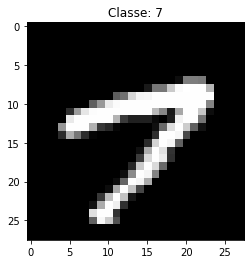

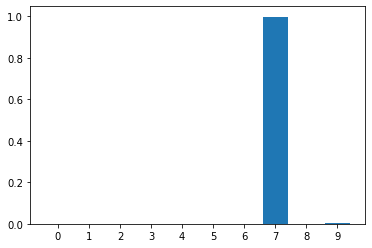

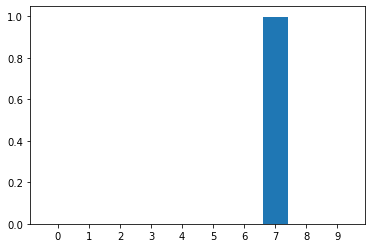

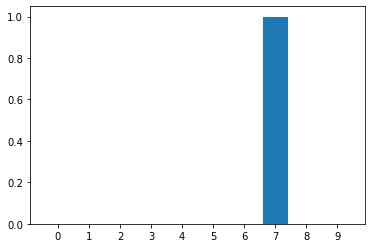

In [27]:
nn1.eval()
nn2.eval()
nn3.eval()

indice = 3
utils.show_bw_image(data[indice], title=f"Classe: {labels[indice].item()}")
utils.plot_nn_output(nn1(data[indice].to(device)))
utils.plot_nn_output(nn2(data[indice].to(device)))
utils.plot_nn_output(nn3(data[indice].to(device)))

Abbiamo visto che i nostri modelli hanno tutti un'accuratezza superiore al $95\%$. Questo significa che vi sono degli errori. Come si comportano le reti su questi errori?

Iniziamo dall'estrarre alcuni errori della prima rete...

... 0
15
5


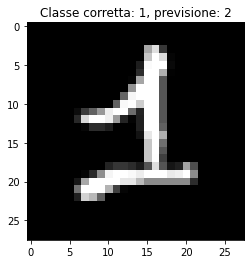

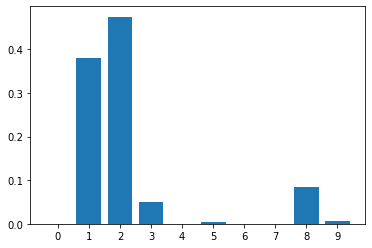

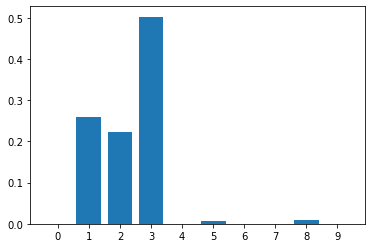

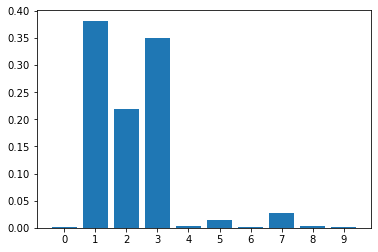

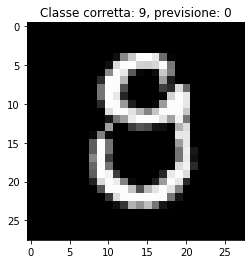

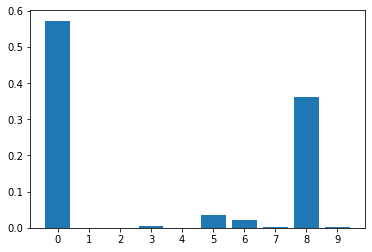

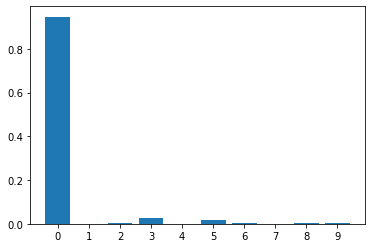

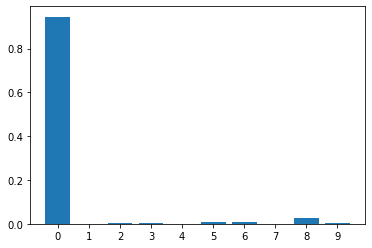

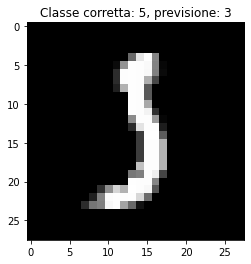

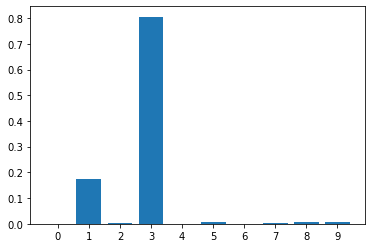

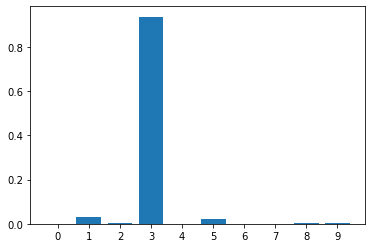

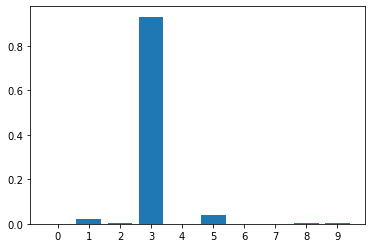

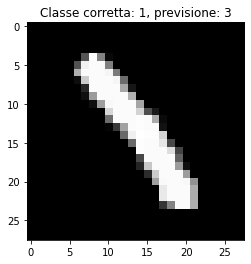

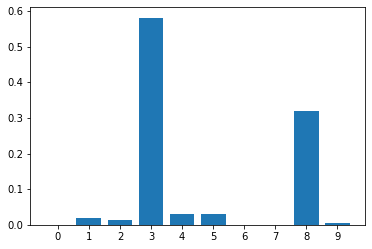

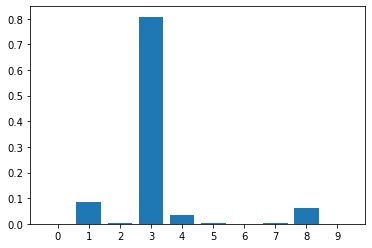

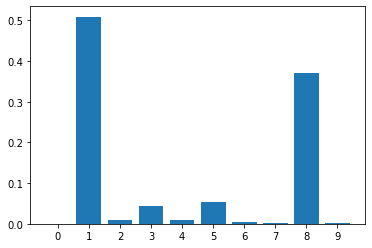

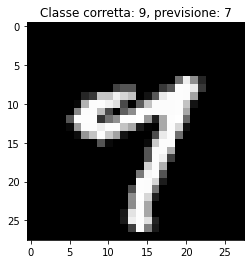

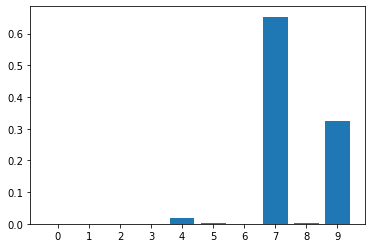

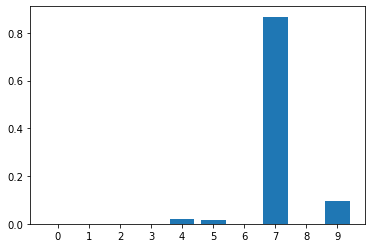

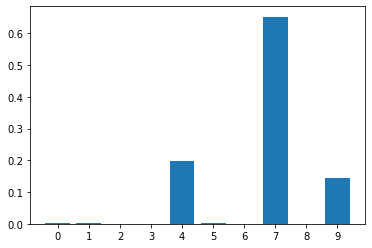

In [29]:
immagini_errore, classe_corretta, previsione = utils.get_first_n_error(nn1, testloader)

for i in range(len(immagini_errore)):
    utils.show_bw_image(immagini_errore[i], title=f"Classe corretta: {classe_corretta[i]}, previsione: {previsione[i]}")
    utils.plot_nn_output(nn1(immagini_errore[i]))
    utils.plot_nn_output(nn2(immagini_errore[i]))
    utils.plot_nn_output(nn3(immagini_errore[i]))

ora con la seconda...

... 0
16
5


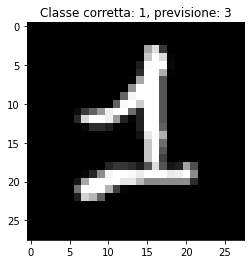

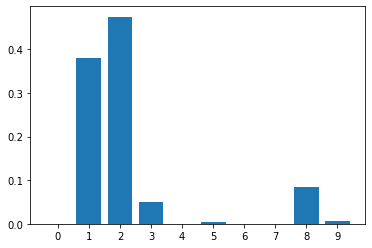

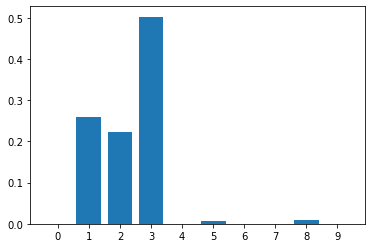

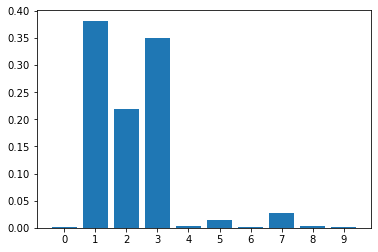

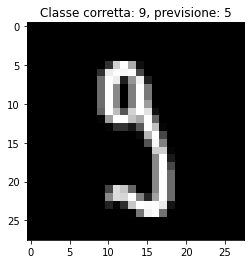

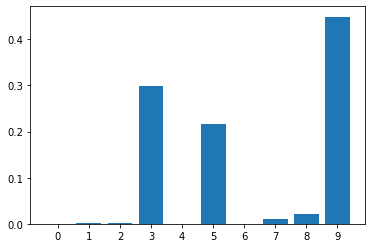

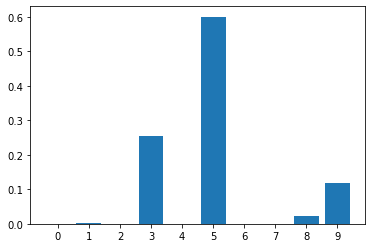

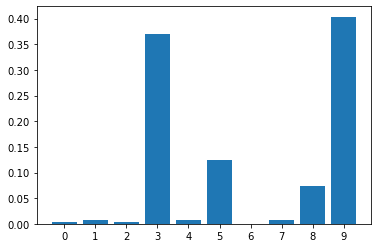

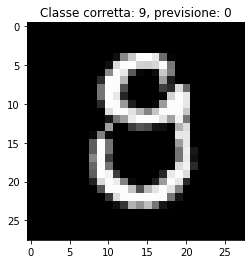

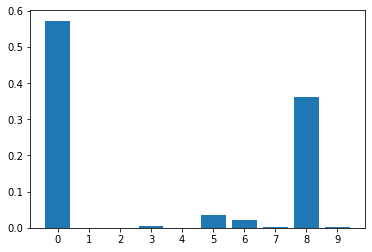

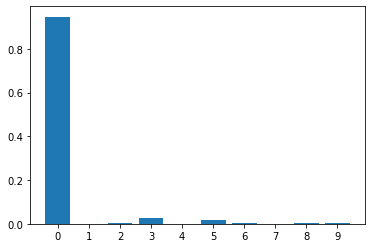

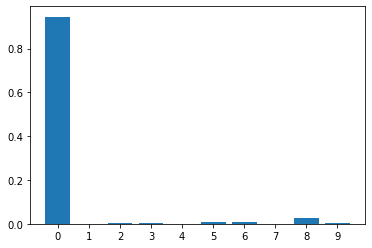

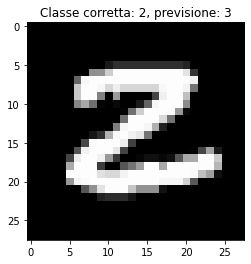

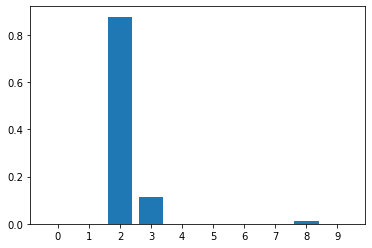

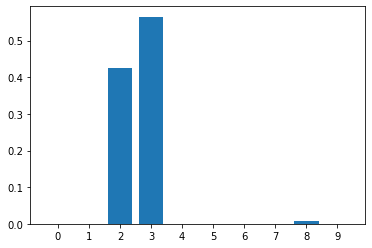

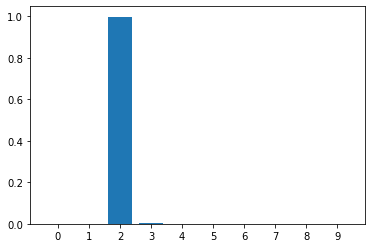

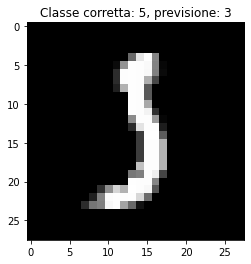

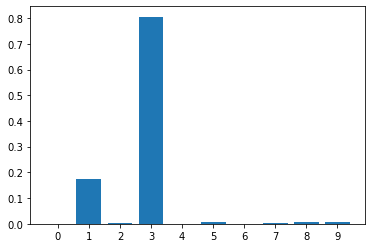

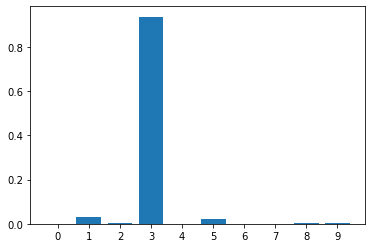

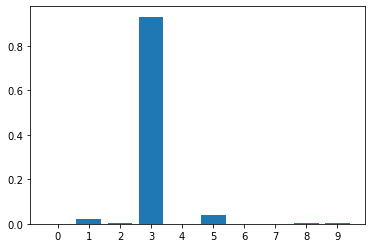

In [30]:
immagini_errore, classe_corretta, previsione = utils.get_first_n_error(nn2, testloader)

for i in range(len(immagini_errore)):
    utils.show_bw_image(immagini_errore[i], title=f"Classe corretta: {classe_corretta[i]}, previsione: {previsione[i]}")
    utils.plot_nn_output(nn1(immagini_errore[i]))
    utils.plot_nn_output(nn2(immagini_errore[i]))
    utils.plot_nn_output(nn3(immagini_errore[i]))

...e ora la terza

... 0
9
5


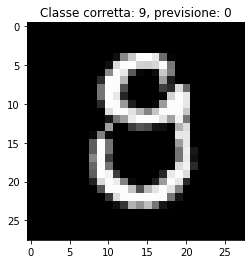

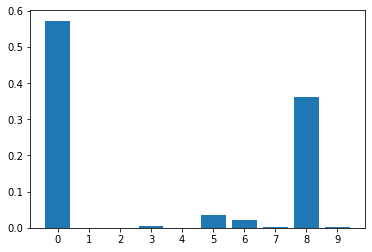

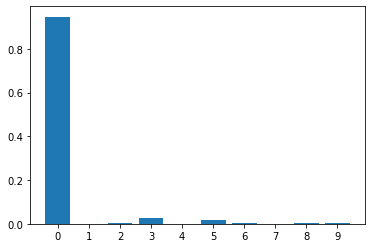

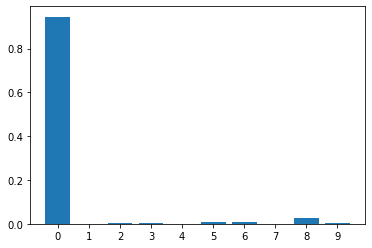

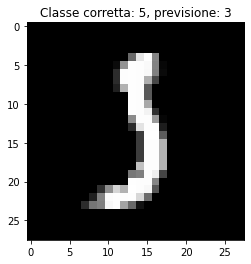

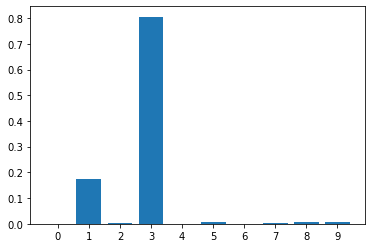

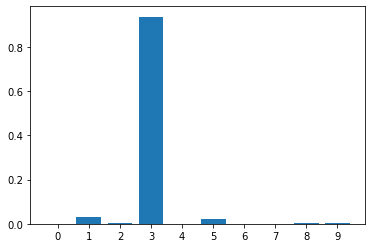

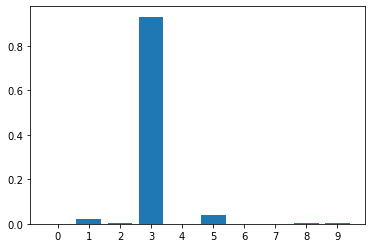

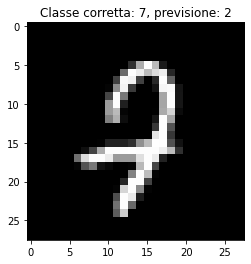

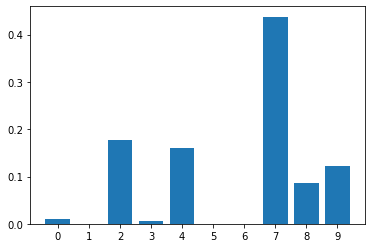

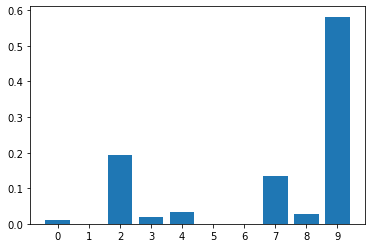

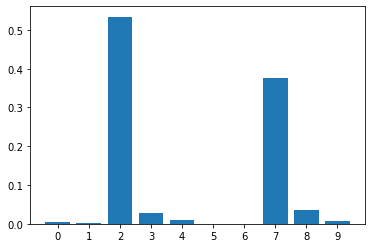

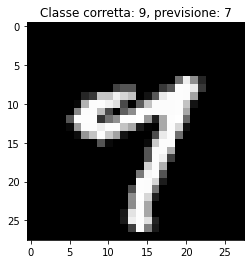

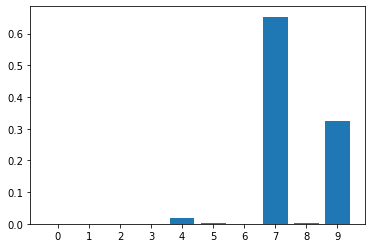

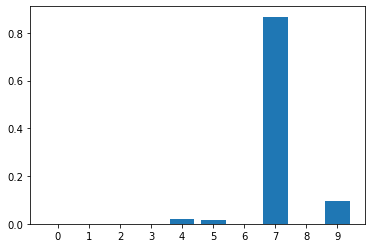

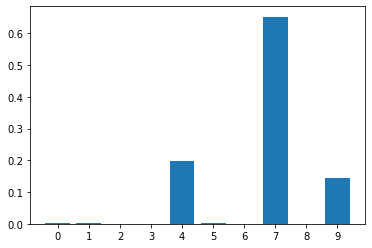

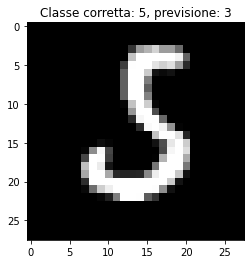

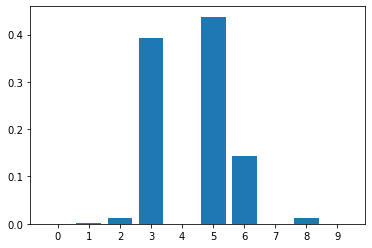

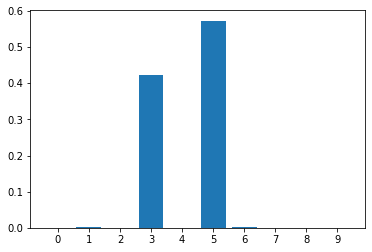

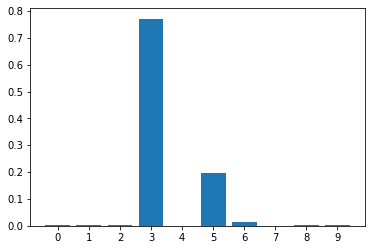

In [31]:
immagini_errore, classe_corretta, previsione = utils.get_first_n_error(nn3, testloader)

for i in range(len(immagini_errore)):
    utils.show_bw_image(immagini_errore[i], title=f"Classe corretta: {classe_corretta[i]}, previsione: {previsione[i]}")
    utils.plot_nn_output(nn1(immagini_errore[i]))
    utils.plot_nn_output(nn2(immagini_errore[i]))
    utils.plot_nn_output(nn3(immagini_errore[i]))

Ora arriviamo ad un problema tipico delle reti neurali: nonostante l'accuratezza dei modelli più complessi migliori su immagini "reali", abbiamo un problema di "sovra-addestramento" su immagini non reali - in pratica più il modello è complicato, più sarà "forzato" ad effettuare una predizione _confidente_ su **qualsiasi** immagine gli venga data in pasto, _anche se completamente casuale_.

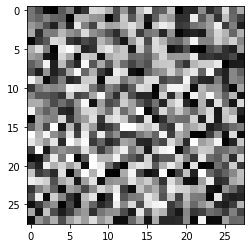

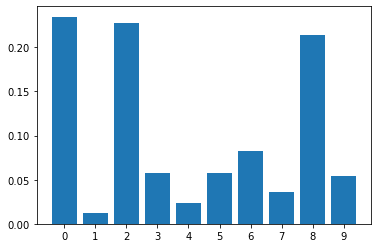

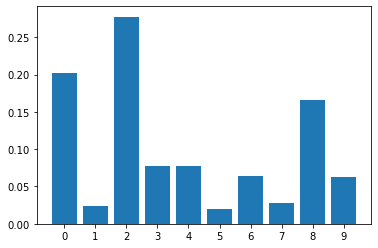

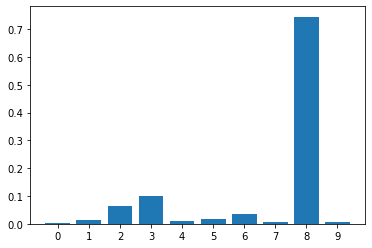

In [107]:
random_image = torch.rand_like(data[0])*2-1
utils.show_bw_image(random_image)
utils.plot_nn_output(nn1(random_image))
utils.plot_nn_output(nn2(random_image))
utils.plot_nn_output(nn3(random_image))

## Ora è il vostro turno, provate ad imbrogliare la rete!

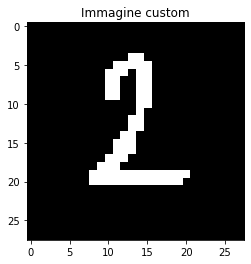

In [122]:
immagine_custom = cv2.imread("immagini/7.png", cv2.IMREAD_GRAYSCALE)
utils.show_bw_image(immagine_custom, "Immagine custom")

Classe: 2


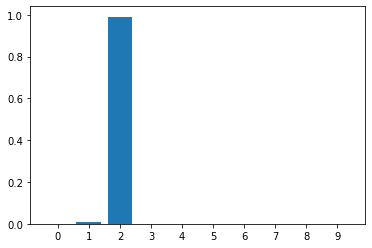

Classe: 2


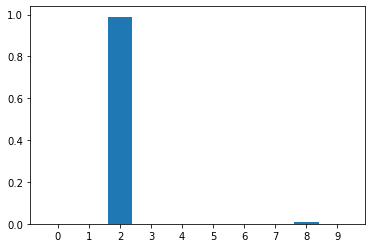

Classe: 2


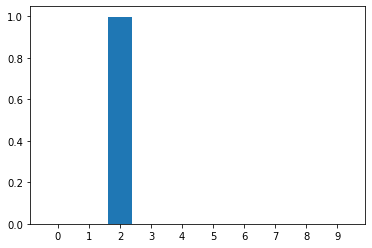

In [123]:
out1, cl1 = utils.evaluate_single_data(nn1, immagine_custom, data_transforms)
out2, cl2 = utils.evaluate_single_data(nn2, immagine_custom, data_transforms)
out3, cl3 = utils.evaluate_single_data(nn3, immagine_custom, data_transforms)

print(f"Classe: {cl1.item()}")
utils.plot_nn_output(out1)
print(f"Classe: {cl2.item()}")
utils.plot_nn_output(out2)
print(f"Classe: {cl3.item()}")
utils.plot_nn_output(out3)

### Addestramento della rete

Qui sotto trovate il codice che ho utilizzato per addestare le reti, nel caso in cui vogliate provare con mano ciò.

In [16]:
# Ottimizzatore - io ho usato ADAM, ma è possibile usarne uno qualsiasi

optimizer1 = torch.optim.Adam(nn1.parameters())
optimizer2 = torch.optim.Adam(nn2.parameters())
optimizer3 = torch.optim.Adam(nn3.parameters())

In [17]:
# addestramento vero e proprio

train.train_model(nn1, trainloader, nn.CrossEntropyLoss(), optimizer1, num_epochs=5, checkpoint_loc="models", checkpoint_name="model1.pt")
train.test_model(nn1, testloader)

Epoch 1 --- learning rate 0.00100
Epoch 1 completed. Loss - total: 24616.9189 - average: 0.4103; Performance: 0.8822
Epoch 2 --- learning rate 0.00100
Epoch 2 completed. Loss - total: 12367.3822 - average: 0.2061; Performance: 0.9396
Epoch 3 --- learning rate 0.00100
Epoch 3 completed. Loss - total: 10038.7689 - average: 0.1673; Performance: 0.9515
Epoch 4 --- learning rate 0.00100
Epoch 4 completed. Loss - total: 8522.3166 - average: 0.1420; Performance: 0.9588
Epoch 5 --- learning rate 0.00100
Epoch 5 completed. Loss - total: 7530.9928 - average: 0.1255; Performance: 0.9630
TESTING - loss -- - performance 0.9676


(None, 0.9675833333333334)

In [18]:
train.train_model(nn2, trainloader, nn.CrossEntropyLoss(), optimizer2, num_epochs=5, checkpoint_loc="models", checkpoint_name="model2.pt")
train.test_model(nn2, testloader)

Epoch 1 --- learning rate 0.00100
Epoch 1 completed. Loss - total: 24856.1538 - average: 0.4143; Performance: 0.8815
Epoch 2 --- learning rate 0.00100
Epoch 2 completed. Loss - total: 11544.0848 - average: 0.1924; Performance: 0.9433
Epoch 3 --- learning rate 0.00100
Epoch 3 completed. Loss - total: 8873.7572 - average: 0.1479; Performance: 0.9574
Epoch 4 --- learning rate 0.00100
Epoch 4 completed. Loss - total: 7543.0538 - average: 0.1257; Performance: 0.9629
Epoch 5 --- learning rate 0.00100
Epoch 5 completed. Loss - total: 6544.3123 - average: 0.1091; Performance: 0.9670
TESTING - loss -- - performance 0.9708


(None, 0.9708333333333333)

In [19]:
train.train_model(nn3, trainloader, nn.CrossEntropyLoss(), optimizer3, num_epochs=5, checkpoint_loc="models", checkpoint_name="model3.pt")
train.test_model(nn3, testloader)

Epoch 1 --- learning rate 0.00100
Epoch 1 completed. Loss - total: 25125.9883 - average: 0.4188; Performance: 0.8793
Epoch 2 --- learning rate 0.00100
Epoch 2 completed. Loss - total: 11776.6311 - average: 0.1963; Performance: 0.9434
Epoch 3 --- learning rate 0.00100
Epoch 3 completed. Loss - total: 9047.3029 - average: 0.1508; Performance: 0.9549
Epoch 4 --- learning rate 0.00100
Epoch 4 completed. Loss - total: 7718.6855 - average: 0.1286; Performance: 0.9618
Epoch 5 --- learning rate 0.00100
Epoch 5 completed. Loss - total: 6719.6545 - average: 0.1120; Performance: 0.9670
TESTING - loss -- - performance 0.9821


(None, 0.9821166666666666)